In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/homeloan/home_loan_test.csv
/kaggle/input/homeloan/home_loan_train.csv
/kaggle/input/notebook-7/sample_submission.csv
/kaggle/input/notebook-7/bureau_balance.csv
/kaggle/input/notebook-7/POS_CASH_balance.csv
/kaggle/input/notebook-7/application_train.csv
/kaggle/input/notebook-7/application_data.csv
/kaggle/input/notebook-7/HomeCredit_columns_description.csv
/kaggle/input/notebook-7/credit_card_balance.csv
/kaggle/input/notebook-7/installments_payments.csv
/kaggle/input/notebook-7/bureau.csv
/kaggle/input/bank-loan-default/application_data.csv
/kaggle/input/bank-loan-default/previous_application.csv
/kaggle/input/bank-loan-default/columns_description.csv


In [4]:
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [5]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

In [6]:
# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [7]:
# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows = None, nan_as_category = False):
    # Read data and merge
    df = pd.read_csv('../input/notebook-7/application_train.csv', nrows= num_rows)
    test_df = pd.read_csv('../input/homeloan/home_loan_test.csv', nrows= num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = df.append(test_df).reset_index()
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df
application_train_test()

Train samples: 307511, test samples: 48744


,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE
0,0,100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,...,0,1,0,1,0,0.067329,0.498036,202500.0,0.121978,0.060749
1,1,100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,...,0,0,0,1,0,0.070862,0.208736,135000.0,0.132217,0.027598
2,2,100004,0.0,0,1,0,0,67500.0,135000.0,6750.0,...,0,0,0,0,0,0.011814,0.500000,67500.0,0.100000,0.050000
3,3,100006,0.0,1,0,0,0,135000.0,312682.5,29686.5,...,0,0,0,0,0,0.159905,0.431748,67500.0,0.219900,0.094941
4,4,100007,0.0,0,0,0,0,121500.0,513000.0,21865.5,...,0,0,0,0,0,0.152418,0.236842,121500.0,0.179963,0.042623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356250,48739,456221,NaN,1,0,0,0,121500.0,412560.0,17473.5,...,0,0,0,0,0,0.258838,0.294503,121500.0,0.143815,0.042354
356251,48740,456222,NaN,1,0,1,2,157500.0,622413.0,31909.5,...,0,0,0,0,0,0.102718,0.253047,39375.0,0.202600,0.051267
356252,48741,456223,NaN,1,1,0,1,202500.0,315000.0,33205.5,...,0,1,0,1,0,0.190742,0.642857,67500.0,0.163978,0.105414
356253,48742,456224,NaN,0,0,1,0,225000.0,450000.0,25128.0,...,1,0,0,1,0,0.195518,0.500000,112500.0,0.111680,0.055840


In [8]:
# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv('../input/notebook-7/bureau.csv', nrows = num_rows)
    bb = pd.read_csv('../input/notebook-7/bureau_balance.csv', nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg
bureau_and_balance()

,BURO_DAYS_CREDIT_MIN,BURO_DAYS_CREDIT_MAX,BURO_DAYS_CREDIT_MEAN,BURO_DAYS_CREDIT_VAR,BURO_DAYS_CREDIT_ENDDATE_MIN,BURO_DAYS_CREDIT_ENDDATE_MAX,BURO_DAYS_CREDIT_ENDDATE_MEAN,BURO_DAYS_CREDIT_UPDATE_MEAN,BURO_CREDIT_DAY_OVERDUE_MAX,BURO_CREDIT_DAY_OVERDUE_MEAN,...,CLOSED_AMT_CREDIT_SUM_OVERDUE_MEAN,CLOSED_AMT_CREDIT_SUM_LIMIT_MEAN,CLOSED_AMT_CREDIT_SUM_LIMIT_SUM,CLOSED_AMT_ANNUITY_MAX,CLOSED_AMT_ANNUITY_MEAN,CLOSED_CNT_CREDIT_PROLONG_SUM,CLOSED_MONTHS_BALANCE_MIN_MIN,CLOSED_MONTHS_BALANCE_MAX_MAX,CLOSED_MONTHS_BALANCE_SIZE_MEAN,CLOSED_MONTHS_BALANCE_SIZE_SUM
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,-1572,-49,-735.000000,240043.666667,-1329.0,1778.0,82.428571,-93.142857,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-51.0,0.0,35.000000,140.0
100002,-1437,-103,-874.000000,186150.000000,-1072.0,780.0,-349.000000,-499.875000,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-47.0,0.0,15.000000,90.0
100003,-2586,-606,-1400.750000,827783.583333,-2434.0,1216.0,-544.500000,-816.000000,0,0.0,...,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0
100004,-1326,-408,-867.000000,421362.000000,-595.0,-382.0,-488.500000,-532.000000,0,0.0,...,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0
100005,-373,-62,-190.666667,26340.333333,-128.0,1324.0,439.333333,-54.333333,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-12.0,0.0,13.000000,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456249,-2713,-483,-1667.076923,407302.243590,-2499.0,1363.0,-1232.333333,-1064.538462,0,0.0,...,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0
456250,-1002,-760,-862.000000,15724.000000,-272.0,2340.0,1288.333333,-60.333333,0,0.0,...,0.0,0.0,0.0,384147.0,384147.0,0.0,-32.0,0.0,33.000000,33.0
456253,-919,-713,-867.500000,10609.000000,-189.0,1113.0,280.500000,-253.250000,0,0.0,...,0.0,0.0,0.0,58369.5,58369.5,0.0,-30.0,0.0,31.000000,62.0


In [9]:
# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv('../input/bank-loan-default/previous_application.csv', nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg
previous_applications()

,PREV_AMT_ANNUITY_MIN,PREV_AMT_ANNUITY_MAX,PREV_AMT_ANNUITY_MEAN,PREV_AMT_APPLICATION_MIN,PREV_AMT_APPLICATION_MAX,PREV_AMT_APPLICATION_MEAN,PREV_AMT_CREDIT_MIN,PREV_AMT_CREDIT_MAX,PREV_AMT_CREDIT_MEAN,PREV_APP_CREDIT_PERC_MIN,...,REFUSED_HOUR_APPR_PROCESS_START_MAX,REFUSED_HOUR_APPR_PROCESS_START_MEAN,REFUSED_RATE_DOWN_PAYMENT_MIN,REFUSED_RATE_DOWN_PAYMENT_MAX,REFUSED_RATE_DOWN_PAYMENT_MEAN,REFUSED_DAYS_DECISION_MIN,REFUSED_DAYS_DECISION_MAX,REFUSED_DAYS_DECISION_MEAN,REFUSED_CNT_PAYMENT_MEAN,REFUSED_CNT_PAYMENT_SUM
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,3951.000,3951.000,3951.000000,24835.5,24835.5,24835.500,23787.0,23787.0,23787.00,1.044079,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100002,9251.775,9251.775,9251.775000,179055.0,179055.0,179055.000,179055.0,179055.0,179055.00,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100003,6737.310,98356.995,56553.990000,68809.5,900000.0,435436.500,68053.5,1035882.0,484191.00,0.868825,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100004,5357.250,5357.250,5357.250000,24282.0,24282.0,24282.000,20106.0,20106.0,20106.00,1.207699,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100005,4813.200,4813.200,4813.200000,0.0,44617.5,22308.750,0.0,40153.5,20076.75,1.111173,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456251,6605.910,6605.910,6605.910000,40455.0,40455.0,40455.000,40455.0,40455.0,40455.00,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
456252,10074.465,10074.465,10074.465000,57595.5,57595.5,57595.500,56821.5,56821.5,56821.50,1.013622,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
456253,3973.095,5567.715,4770.405000,19413.0,28912.5,24162.750,13945.5,27306.0,20625.75,1.058833,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv('../input/notebook-7/POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg
pos_cash()

,POS_MONTHS_BALANCE_MAX,POS_MONTHS_BALANCE_MEAN,POS_MONTHS_BALANCE_SIZE,POS_SK_DPD_MAX,POS_SK_DPD_MEAN,POS_SK_DPD_DEF_MAX,POS_SK_DPD_DEF_MEAN,POS_NAME_CONTRACT_STATUS_Active_MEAN,POS_NAME_CONTRACT_STATUS_Amortized debt_MEAN,POS_NAME_CONTRACT_STATUS_Approved_MEAN,POS_NAME_CONTRACT_STATUS_Canceled_MEAN,POS_NAME_CONTRACT_STATUS_Completed_MEAN,POS_NAME_CONTRACT_STATUS_Demand_MEAN,POS_NAME_CONTRACT_STATUS_Returned to the store_MEAN,POS_NAME_CONTRACT_STATUS_Signed_MEAN,POS_NAME_CONTRACT_STATUS_XNA_MEAN,POS_NAME_CONTRACT_STATUS_nan_MEAN,POS_COUNT
SK_ID_CURR,,,,,,,,,,,,,,,,,,
100001,-53,-72.555556,9,7,0.777778,7,0.777778,0.777778,0.0,0.0,0.0,0.222222,0.0,0.0,0.000000,0.0,0.0,9
100002,-1,-10.000000,19,0,0.000000,0,0.000000,1.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,19
100003,-18,-43.785714,28,0,0.000000,0,0.000000,0.928571,0.0,0.0,0.0,0.071429,0.0,0.0,0.000000,0.0,0.0,28
100004,-24,-25.500000,4,0,0.000000,0,0.000000,0.750000,0.0,0.0,0.0,0.250000,0.0,0.0,0.000000,0.0,0.0,4
100005,-15,-20.000000,11,0,0.000000,0,0.000000,0.818182,0.0,0.0,0.0,0.090909,0.0,0.0,0.090909,0.0,0.0,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456251,-1,-5.000000,9,0,0.000000,0,0.000000,0.777778,0.0,0.0,0.0,0.111111,0.0,0.0,0.111111,0.0,0.0,9
456252,-76,-79.000000,7,0,0.000000,0,0.000000,0.857143,0.0,0.0,0.0,0.142857,0.0,0.0,0.000000,0.0,0.0,7
456253,-57,-79.235294,17,5,0.294118,5,0.294118,0.882353,0.0,0.0,0.0,0.117647,0.0,0.0,0.000000,0.0,0.0,17


In [11]:
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv('../input/notebook-7/installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg
installments_payments()

,INSTAL_NUM_INSTALMENT_VERSION_NUNIQUE,INSTAL_DPD_MAX,INSTAL_DPD_MEAN,INSTAL_DPD_SUM,INSTAL_DBD_MAX,INSTAL_DBD_MEAN,INSTAL_DBD_SUM,INSTAL_PAYMENT_PERC_MAX,INSTAL_PAYMENT_PERC_MEAN,INSTAL_PAYMENT_PERC_SUM,...,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_COUNT
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,2,11.0,1.571429,11.0,36.0,8.857143,62.0,1.00000,1.000000,7.000000,...,5885.132143,41195.925,3951.000,17397.900,5885.132143,41195.925,-1628.0,-2195.000000,-15365.0,7
100002,2,0.0,0.000000,0.0,31.0,20.421053,388.0,1.00000,1.000000,19.000000,...,11559.247105,219625.695,9251.775,53093.745,11559.247105,219625.695,-49.0,-315.421053,-5993.0,19
100003,2,0.0,0.000000,0.0,14.0,7.160000,179.0,1.00000,1.000000,25.000000,...,64754.586000,1618864.650,6662.970,560835.360,64754.586000,1618864.650,-544.0,-1385.320000,-34633.0,25
100004,2,0.0,0.000000,0.0,11.0,7.666667,23.0,1.00000,1.000000,3.000000,...,7096.155000,21288.465,5357.250,10573.965,7096.155000,21288.465,-727.0,-761.666667,-2285.0,3
100005,2,1.0,0.111111,1.0,37.0,23.666667,213.0,1.00000,1.000000,9.000000,...,6240.205000,56161.845,4813.200,17656.245,6240.205000,56161.845,-470.0,-609.555556,-5486.0,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456251,2,0.0,0.000000,0.0,46.0,36.285714,254.0,1.00000,1.000000,7.000000,...,7492.924286,52450.470,6605.910,12815.010,7492.924286,52450.470,-38.0,-156.285714,-1094.0,7
456252,1,3.0,0.500000,3.0,11.0,3.333333,20.0,1.00000,1.000000,6.000000,...,10069.867500,60419.205,10046.880,10074.465,10069.867500,60419.205,-2327.0,-2393.833333,-14363.0,6
456253,1,9.0,0.642857,9.0,51.0,15.142857,212.0,1.00000,0.928571,13.000000,...,4399.707857,61595.910,27.270,5575.185,4115.915357,57622.815,-1738.0,-2387.428571,-33424.0,14


In [12]:
# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv('../input/notebook-7/credit_card_balance.csv', nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg
credit_card_balance()

,CC_MONTHS_BALANCE_MIN,CC_MONTHS_BALANCE_MAX,CC_MONTHS_BALANCE_MEAN,CC_MONTHS_BALANCE_SUM,CC_MONTHS_BALANCE_VAR,CC_AMT_BALANCE_MIN,CC_AMT_BALANCE_MAX,CC_AMT_BALANCE_MEAN,CC_AMT_BALANCE_SUM,CC_AMT_BALANCE_VAR,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100006,-6,-1,-3.5,-21,3.5,0.000,0.000,0.000000,0.000,0.000000e+00,...,0,0.0,0,0.0,0,0,0.0,0,0.0,6
100011,-75,-2,-38.5,-2849,462.5,0.000,189000.000,54482.111149,4031676.225,4.641321e+09,...,0,0.0,0,0.0,0,0,0.0,0,0.0,74
100013,-96,-1,-48.5,-4656,776.0,0.000,161420.220,18159.919219,1743352.245,1.869473e+09,...,0,0.0,0,0.0,0,0,0.0,0,0.0,96
100021,-18,-2,-10.0,-170,25.5,0.000,0.000,0.000000,0.000,0.000000e+00,...,0,0.0,0,0.0,0,0,0.0,0,0.0,17
100023,-11,-4,-7.5,-60,6.0,0.000,0.000,0.000000,0.000,0.000000e+00,...,0,0.0,0,0.0,0,0,0.0,0,0.0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456244,-41,-1,-21.0,-861,143.5,0.000,453627.675,131834.730732,5405223.960,3.295703e+10,...,0,0.0,0,0.0,0,0,0.0,0,0.0,41
456246,-9,-2,-5.5,-44,6.0,0.000,43490.115,13136.731875,105093.855,3.335511e+08,...,0,0.0,0,0.0,0,0,0.0,0,0.0,8
456247,-96,-2,-49.0,-4655,760.0,0.000,190202.130,23216.396211,2205557.640,3.200871e+09,...,0,0.0,0,0.0,0,0,0.0,0,0.0,95


In [13]:
#num_rows = 10000 
df = application_train_test()
df.head()

Train samples: 307511, test samples: 48744


,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE
0,0,100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,...,0,1,0,1,0,0.067329,0.498036,202500.0,0.121978,0.060749
1,1,100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,...,0,0,0,1,0,0.070862,0.208736,135000.0,0.132217,0.027598
2,2,100004,0.0,0,1,0,0,67500.0,135000.0,6750.0,...,0,0,0,0,0,0.011814,0.500000,67500.0,0.100000,0.050000
3,3,100006,0.0,1,0,0,0,135000.0,312682.5,29686.5,...,0,0,0,0,0,0.159905,0.431748,67500.0,0.219900,0.094941
4,4,100007,0.0,0,0,0,0,121500.0,513000.0,21865.5,...,0,0,0,0,0,0.152418,0.236842,121500.0,0.179963,0.042623


In [14]:
df.shape

(356251, 248)

In [15]:
df["TARGET"].notnull().sum()

307507

In [16]:
bureau = bureau_and_balance()
print("Bureau df shape:", bureau.shape)
df= df.join(bureau, how='left', on='SK_ID_CURR')
del bureau
gc.collect()
df.head()

Bureau df shape: (305811, 116)


,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,CLOSED_AMT_CREDIT_SUM_OVERDUE_MEAN,CLOSED_AMT_CREDIT_SUM_LIMIT_MEAN,CLOSED_AMT_CREDIT_SUM_LIMIT_SUM,CLOSED_AMT_ANNUITY_MAX,CLOSED_AMT_ANNUITY_MEAN,CLOSED_CNT_CREDIT_PROLONG_SUM,CLOSED_MONTHS_BALANCE_MIN_MIN,CLOSED_MONTHS_BALANCE_MAX_MAX,CLOSED_MONTHS_BALANCE_SIZE_MEAN,CLOSED_MONTHS_BALANCE_SIZE_SUM
0,0,100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,...,0.0,0.0,0.0,0.0,0.0,0.0,-47.0,0.0,15.0,90.0
1,1,100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,...,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0
2,2,100004,0.0,0,1,0,0,67500.0,135000.0,6750.0,...,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0
3,3,100006,0.0,1,0,0,0,135000.0,312682.5,29686.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,100007,0.0,0,0,0,0,121500.0,513000.0,21865.5,...,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0


In [17]:
prev = previous_applications()
print("Previous applications df shape:", prev.shape)
df = df.join(prev, how='left', on='SK_ID_CURR')
del prev
gc.collect()
df.head()

Previous applications df shape: (338857, 249)


,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,REFUSED_HOUR_APPR_PROCESS_START_MAX,REFUSED_HOUR_APPR_PROCESS_START_MEAN,REFUSED_RATE_DOWN_PAYMENT_MIN,REFUSED_RATE_DOWN_PAYMENT_MAX,REFUSED_RATE_DOWN_PAYMENT_MEAN,REFUSED_DAYS_DECISION_MIN,REFUSED_DAYS_DECISION_MAX,REFUSED_DAYS_DECISION_MEAN,REFUSED_CNT_PAYMENT_MEAN,REFUSED_CNT_PAYMENT_SUM
0,0,100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,100004,0.0,0,1,0,0,67500.0,135000.0,6750.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,100006,0.0,1,0,0,0,135000.0,312682.5,29686.5,...,15.0,15.0,NaN,NaN,NaN,-181.0,-181.0,-181.0,48.0,48.0
4,4,100007,0.0,0,0,0,0,121500.0,513000.0,21865.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
pos = pos_cash()
print("Pos-cash balance df shape:", pos.shape)
df = df.join(pos, how='left', on='SK_ID_CURR')
del pos
gc.collect()
df.head()

Pos-cash balance df shape: (337252, 18)


,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,POS_NAME_CONTRACT_STATUS_Amortized debt_MEAN,POS_NAME_CONTRACT_STATUS_Approved_MEAN,POS_NAME_CONTRACT_STATUS_Canceled_MEAN,POS_NAME_CONTRACT_STATUS_Completed_MEAN,POS_NAME_CONTRACT_STATUS_Demand_MEAN,POS_NAME_CONTRACT_STATUS_Returned to the store_MEAN,POS_NAME_CONTRACT_STATUS_Signed_MEAN,POS_NAME_CONTRACT_STATUS_XNA_MEAN,POS_NAME_CONTRACT_STATUS_nan_MEAN,POS_COUNT
0,0,100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,19.0
1,1,100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,...,0.0,0.0,0.0,0.071429,0.0,0.000000,0.000000,0.0,0.0,28.0
2,2,100004,0.0,0,1,0,0,67500.0,135000.0,6750.0,...,0.0,0.0,0.0,0.250000,0.0,0.000000,0.000000,0.0,0.0,4.0
3,3,100006,0.0,1,0,0,0,135000.0,312682.5,29686.5,...,0.0,0.0,0.0,0.095238,0.0,0.047619,0.000000,0.0,0.0,21.0
4,4,100007,0.0,0,0,0,0,121500.0,513000.0,21865.5,...,0.0,0.0,0.0,0.045455,0.0,0.000000,0.015152,0.0,0.0,66.0


In [19]:
ins = installments_payments()
print("Installments payments df shape:", ins.shape)
df = df.join(ins, how='left', on='SK_ID_CURR')
del ins
gc.collect()
df.head()

Installments payments df shape: (339587, 26)


,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_COUNT
0,0,100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,...,11559.247105,219625.695,9251.775,53093.745,11559.247105,219625.695,-49.0,-315.421053,-5993.0,19.0
1,1,100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,...,64754.586000,1618864.650,6662.970,560835.360,64754.586000,1618864.650,-544.0,-1385.320000,-34633.0,25.0
2,2,100004,0.0,0,1,0,0,67500.0,135000.0,6750.0,...,7096.155000,21288.465,5357.250,10573.965,7096.155000,21288.465,-727.0,-761.666667,-2285.0,3.0
3,3,100006,0.0,1,0,0,0,135000.0,312682.5,29686.5,...,62947.088438,1007153.415,2482.920,691786.890,62947.088438,1007153.415,-12.0,-271.625000,-4346.0,16.0
4,4,100007,0.0,0,0,0,0,121500.0,513000.0,21865.5,...,12666.444545,835985.340,0.180,22678.785,12214.060227,806127.975,-14.0,-1032.242424,-68128.0,66.0


In [20]:
cc = credit_card_balance()
print("Credit card balance df shape:", cc.shape)
df = df.join(cc, how='left', on='SK_ID_CURR')
del cc
gc.collect()
df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
df.head()

Credit card balance df shape: (103558, 141)


,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
0,0,100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,100004,0.0,0,1,0,0,67500.0,135000.0,6750.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,100006,0.0,1,0,0,0,135000.0,312682.5,29686.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
4,4,100007,0.0,0,0,0,0,121500.0,513000.0,21865.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
df.shape

(356251, 798)

In [22]:
#Nombre de classes uniques dans chaque colonne
df.select_dtypes('object').nunique()

Series([], dtype: float64)

In [23]:
df.head()

,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
0,0,100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,100004,0.0,0,1,0,0,67500.0,135000.0,6750.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,100006,0.0,1,0,0,0,135000.0,312682.5,29686.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
4,4,100007,0.0,0,0,0,0,121500.0,513000.0,21865.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
#heatmap des valeurs manquantes (black)
#plt.figure(figsize=(20,10))
#sns.heatmap(df.notna(), cbar=False)
#plt.show()

In [25]:
def nan_check(data):
    total = data.isnull().sum()
    percent_1 = data.isnull().sum()/data.isnull().count()*100
    percent_2 = (np.round(percent_1, 2))
    missing_data = pd.concat([total, percent_2], 
                             axis=1, keys=['Total', '%']).sort_values('%', ascending=False)
    return missing_data

In [26]:
print('TOP 10 des valeurs manquantes de Training dataset')
nan_check(df)[:40]

TOP 10 des valeurs manquantes de Training dataset


,Total,%
REFUSED_RATE_DOWN_PAYMENT_MAX,303648,85.23
REFUSED_RATE_DOWN_PAYMENT_MIN,303648,85.23
REFUSED_AMT_DOWN_PAYMENT_MEAN,303648,85.23
REFUSED_RATE_DOWN_PAYMENT_MEAN,303648,85.23
REFUSED_AMT_DOWN_PAYMENT_MAX,303648,85.23
REFUSED_AMT_DOWN_PAYMENT_MIN,303648,85.23
REFUSED_APP_CREDIT_PERC_VAR,298034,83.66
CC_AMT_PAYMENT_CURRENT_VAR,284649,79.90
CC_CNT_DRAWINGS_ATM_CURRENT_VAR,284559,79.88
CC_CNT_DRAWINGS_OTHER_CURRENT_VAR,284559,79.88


In [27]:
threshold = 0.5 * df.shape[0]

data = df.dropna(axis=1, thresh=threshold)

In [28]:
data.shape

(356251, 565)

In [29]:
print('Missing values in  data: ', sum(data.isnull().sum()))

Missing values in  data:  14102762


In [30]:
data_1=data.sample(10000)

In [31]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')
data_1.iloc[:,:]= imputer.fit_transform(data_1)

In [32]:
sum(data_1.isnull().sum())

0

In [33]:
data_1.head()

,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_COUNT
219209,219209.0,353940.0,0.0,1.0,0.0,0.0,0.0,180000.0,544491.0,17694.0,...,21275.201489,1999868.940,26.010,411181.785,21007.211170,1974677.850,-26.0,-1047.010638,-98419.0,94.0
107162,107162.0,224330.0,0.0,0.0,0.0,0.0,1.0,112500.0,284400.0,22599.0,...,18467.782500,221613.390,11679.930,51826.770,18467.782500,221613.390,-27.0,-395.166667,-4742.0,12.0
263809,263809.0,405457.0,0.0,0.0,1.0,1.0,2.0,193500.0,900000.0,45720.0,...,6683.229000,33416.145,5590.485,11054.205,6683.229000,33416.145,-2477.0,-2564.000000,-12820.0,5.0
47443,47443.0,154940.0,1.0,0.0,0.0,0.0,2.0,157500.0,254700.0,17019.0,...,10868.213571,228232.485,1096.335,93692.835,10650.857143,223668.000,-53.0,-383.857143,-8061.0,21.0
89210,89210.0,203579.0,0.0,1.0,0.0,0.0,0.0,81000.0,238500.0,13446.0,...,7065.662727,77722.290,97.470,7072.470,6422.710909,70649.820,-610.0,-756.727273,-8324.0,11.0


In [34]:
data_1.shape

(10000, 565)

In [35]:
data_1.columns

Index(['index', 'SK_ID_CURR', 'TARGET', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY',
       ...
       'INSTAL_AMT_INSTALMENT_MEAN', 'INSTAL_AMT_INSTALMENT_SUM',
       'INSTAL_AMT_PAYMENT_MIN', 'INSTAL_AMT_PAYMENT_MAX',
       'INSTAL_AMT_PAYMENT_MEAN', 'INSTAL_AMT_PAYMENT_SUM',
       'INSTAL_DAYS_ENTRY_PAYMENT_MAX', 'INSTAL_DAYS_ENTRY_PAYMENT_MEAN',
       'INSTAL_DAYS_ENTRY_PAYMENT_SUM', 'INSTAL_COUNT'],
      dtype='object', length=565)

In [36]:
data_1.describe()

,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_COUNT
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,1.000000e+04,10000.000000,...,10000.000000,1.000000e+04,10000.000000,1.000000e+04,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000
mean,136354.76150,278638.288700,0.072000,0.664700,0.344400,0.309800,0.414800,1.698901e+05,5.884398e+05,27497.324250,...,18383.099692,6.733652e+05,5105.647796,1.400261e+05,18664.671640,6.787148e+05,-317.091900,-921.578574,-42119.103900,39.835400
std,93421.66874,102687.729229,0.258501,0.472119,0.475196,0.462434,0.724012,1.006627e+05,3.981401e+05,14703.479861,...,24597.829435,8.924516e+05,16282.091914,2.557404e+05,25759.256337,9.281248e+05,526.485679,585.605175,57451.856892,40.903044
min,6.00000,100019.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.700000e+04,4.500000e+04,2412.000000,...,508.761429,3.172590e+03,0.000000,9.900450e+02,508.761429,3.172590e+03,-2917.000000,-2917.000000,-482208.000000,1.000000
25%,45515.25000,188994.750000,0.000000,0.000000,0.000000,0.000000,0.000000,1.125000e+05,2.700000e+05,16875.000000,...,7991.379947,1.410058e+05,49.241250,1.470992e+04,7647.819911,1.375667e+05,-374.000000,-1308.940642,-47663.250000,13.000000
50%,130425.50000,278126.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.530000e+05,5.013765e+05,25128.000000,...,12559.069909,3.384751e+05,2142.315000,3.619373e+04,12142.096342,3.304426e+05,-67.000000,-803.932432,-21363.000000,25.000000
75%,217620.25000,366641.750000,0.000000,1.000000,1.000000,1.000000,1.000000,2.025000e+05,7.921620e+05,34695.000000,...,20577.285625,8.211489e+05,6653.778750,1.303949e+05,20565.544514,8.070125e+05,-27.000000,-451.817982,-7225.250000,49.250000
max,307440.00000,456178.000000,1.000000,1.000000,1.000000,1.000000,11.000000,3.150000e+06,2.517300e+06,177826.500000,...,905408.595000,9.466143e+06,905408.595000,3.771488e+06,905408.595000,1.008731e+07,-2.000000,-12.000000,-12.000000,336.000000


In [37]:
#Distribution of the Target Column
data_1['TARGET'].value_counts()

0.0    9280
1.0     720
Name: TARGET, dtype: int64

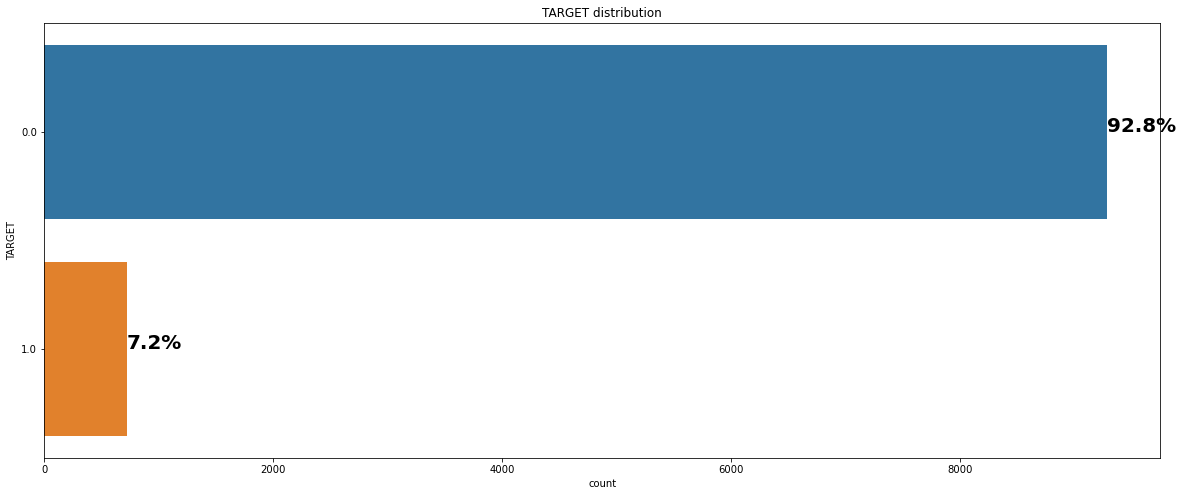

In [38]:
ax, fig = plt.subplots(figsize=(20,8)) 
ax = sns.countplot(y='TARGET', data=data_1)
ax.set_title("TARGET distribution")

for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/len(data_1.TARGET))
        x = p.get_x() + p.get_width()
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y), fontsize=20, fontweight='bold')
        
show()

In [39]:
from sklearn.model_selection import train_test_split
feat = [f for f in data_1.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
X=data_1[feat]
Y= data_1["TARGET"]
X_train, X_test, y_train, y_test = train_test_split(
X,Y, test_size=0.3, random_state=42)

In [40]:
X_train.shape, X_test.shape

((7000, 562), (3000, 562))

In [41]:
y_train.shape, y_test.shape

((7000,), (3000,))

In [42]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)

dummy_clf.predict(X_test)

dummy_clf.score(X_test, y_test)


0.9303333333333333

In [45]:
def cf_matrix_roc_auc(model, y_true, y_pred, y_pred_proba):

    fig = plt.figure(figsize=(20,15))
  
     
    plt.subplot(222)
    fpr,tpr,thresholds = roc_curve(y_true, y_pred_proba)
    plt.plot(fpr, tpr, color='orange', linewidth=5, label='AUC = %0.4f'%roc_auc )
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()


    #sns.barplot(x=data.columns, y=model, color=("orange"))
    plt.xlabel('Features importance')
    plt.xticks(rotation=90)

    show()


In [47]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier

In [48]:
# Initialze the estimators
clf1 = RandomForestClassifier(random_state=42)
clf2 = SVC(probability=True, random_state=42)
clf3 = LogisticRegression(random_state=42)
clf4 = DecisionTreeClassifier(random_state=42)
clf5 = KNeighborsClassifier()
clf6 = MultinomialNB()
clf7 = GradientBoostingClassifier(random_state=42)

In [49]:
# Initiaze the hyperparameters for each dictionary
param1 = {}
param1['classifier__n_estimators'] = [10, 50, 100, 250]
param1['classifier__max_depth'] = [5, 10, 20]
param1['classifier__class_weight'] = [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]
param1['classifier'] = [clf1]

param2 = {}
param2['classifier__C'] = [10**-2, 10**-1, 10**0, 10**1, 10**2]
param2['classifier__class_weight'] = [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]
param2['classifier'] = [clf2]

param3 = {}
param3['classifier__C'] = [10**-2, 10**-1, 10**0, 10**1, 10**2]
param3['classifier__penalty'] = ['l1', 'l2']
param3['classifier__class_weight'] = [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]
param3['classifier'] = [clf3]

param4 = {}
param4['classifier__max_depth'] = [5,10,25,None]
param4['classifier__min_samples_split'] = [2,5,10]
param4['classifier__class_weight'] = [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]
param4['classifier'] = [clf4]

param5 = {}
param5['classifier__n_neighbors'] = [2,5,10,25,50]
param5['classifier'] = [clf5]

param6 = {}
param6['classifier__alpha'] = [10**0, 10**1, 10**2]
param6['classifier'] = [clf6]

param7 = {}
param7['classifier__n_estimators'] = [10, 50, 100, 250]
param7['classifier__max_depth'] = [5, 10, 20]
param7['classifier'] = [clf7]


In [50]:
from sklearn.pipeline import Pipeline
pipeline = Pipeline([('classifier', clf1)])
params = [param1, param2, param3, param4, param5, param6, param7]

In [51]:
%%time
from sklearn.model_selection import RandomizedSearchCV
# Train the random search model
rs = RandomizedSearchCV(pipeline, params, cv=3, n_jobs=-1, scoring='roc_auc').fit(X_train, y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
3 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

CPU times: user 11.2 s, sys: 280 ms, total: 11.5 s
Wall time: 3min 20s


In [52]:
# Best performing model and its corresponding hyperparameters
rs.best_params_

{'classifier__n_estimators': 250,
 'classifier__max_depth': 20,
 'classifier__class_weight': {0: 1, 1: 5},
 'classifier': RandomForestClassifier(class_weight={0: 1, 1: 5}, max_depth=20,
                        n_estimators=250, random_state=42)}

In [53]:
# ROC-AUC score for the best model
roc_auc= rs.best_score_
print('AUC : %0.4f' %roc_auc)

AUC : 0.7238


In [54]:
#'param_classifier'
pd.DataFrame(rs.cv_results_)[['param_classifier','mean_fit_time', 'split0_test_score',
       'split1_test_score', 'split2_test_score',
        'mean_test_score', 'rank_test_score']].sort_values(
    by='rank_test_score')

,param_classifier,mean_fit_time,split0_test_score,split1_test_score,split2_test_score,mean_test_score,rank_test_score
1,"RandomForestClassifier(class_weight={0: 1, 1: ...",9.475533,0.740796,0.706372,0.724374,0.723847,1
7,"RandomForestClassifier(class_weight={0: 1, 1: ...",1.812141,0.690713,0.696754,0.702773,0.696747,2
6,"RandomForestClassifier(class_weight={0: 1, 1: ...",1.882854,0.672361,0.674136,0.678616,0.675038,3
0,"RandomForestClassifier(class_weight={0: 1, 1: ...",3.014890,0.683329,0.666245,0.656719,0.668764,4
2,GradientBoostingClassifier(random_state=42),97.987695,0.639928,0.685706,0.661520,0.662385,5
9,"RandomForestClassifier(class_weight={0: 1, 1: ...",0.444430,0.621678,0.672697,0.638592,0.644322,6
5,"RandomForestClassifier(class_weight={0: 1, 1: ...",0.415802,0.605644,0.600672,0.594857,0.600391,7
8,"SVC(probability=True, random_state=42)",74.487184,0.580123,0.576049,0.578994,0.578389,8
4,"SVC(probability=True, random_state=42)",10.752067,0.541305,0.534146,0.516230,0.530560,9
3,LogisticRegression(random_state=42),0.019566,NaN,NaN,NaN,NaN,10


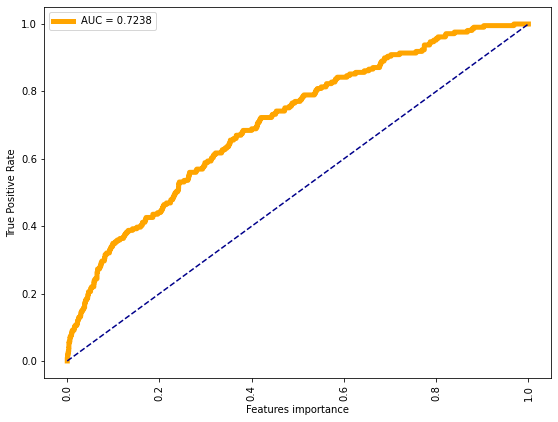

In [55]:
cf_matrix_roc_auc(rs, y_test, rs.predict(X_test), rs.predict_proba(X_test)[:,1])

In [56]:
# Initialze the estimators
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
clf8 = LGBMClassifier(boosting_type="gbdt",verbose=-1,n_jobs=-2,random_state=101,objective='binary')
clf9 = XGBClassifier(objective="binary:logistic",random_state=0)


In [57]:
# Initiaze the hyperparameters for each dictionary
param8 = {}
param8['classifier__n_estimators'] = [100,500,1000]
param8['classifier__learning_rate'] = [0.02, 0.05,0.1,0.2]
param8['classifier__colsample_bytree'] = [0.3,0.4,0.6]
param8['classifier__reg_alpha'] = [0,1,2, 50]
param8['classifier__reg_lambda'] = [0.01,0,1, 20, 50]
param8['classifier__subsample'] = [0.2, 0.5, 0.8]
param8['classifier__max_depth'] = [4, 7,8, 10,11,20]
param8['classifier__num_leaves'] = [6,10,11,20, 30]
param8['classifier__min_child_samples'] = [10,90,100,300, 500]
param8['classifier__min_child_weight'] = [1e-3, 1,1e1, 1e2]
param8['classifier__is_unbalance'] =[True]
param8['classifier'] = [clf8]

param9 = {}
param9['classifier__tree_method'] = ['gpu_hist', 'auto', 'exact', 'approx']
param9['classifier__predictor'] = ['auto', 'cpu_predictor', 'gpu_predictor']
param9['classifier__interaction_constraints']=[[0, 1], [2, 3, 4]] 
param9['classifier__scale_pos_weight']=[1,14.38] 
param9['classifier__max_delta_step']=[0,1,2,3,4,5,6,7,8,9,10]
param9['classifier'] = [clf9]



In [58]:
from sklearn.pipeline import Pipeline
pipeline = Pipeline([('classifier', clf8)])
params = [param8, param9]

In [59]:
LGBMClassifier().get_params().keys()

dict_keys(['boosting_type', 'class_weight', 'colsample_bytree', 'importance_type', 'learning_rate', 'max_depth', 'min_child_samples', 'min_child_weight', 'min_split_gain', 'n_estimators', 'n_jobs', 'num_leaves', 'objective', 'random_state', 'reg_alpha', 'reg_lambda', 'silent', 'subsample', 'subsample_for_bin', 'subsample_freq'])

In [60]:
XGBClassifier().get_params().keys()

dict_keys(['objective', 'use_label_encoder', 'base_score', 'booster', 'callbacks', 'colsample_bylevel', 'colsample_bynode', 'colsample_bytree', 'early_stopping_rounds', 'enable_categorical', 'eval_metric', 'gamma', 'gpu_id', 'grow_policy', 'importance_type', 'interaction_constraints', 'learning_rate', 'max_bin', 'max_cat_to_onehot', 'max_delta_step', 'max_depth', 'max_leaves', 'min_child_weight', 'missing', 'monotone_constraints', 'n_estimators', 'n_jobs', 'num_parallel_tree', 'predictor', 'random_state', 'reg_alpha', 'reg_lambda', 'sampling_method', 'scale_pos_weight', 'subsample', 'tree_method', 'validate_parameters', 'verbosity'])

In [61]:
%%time
from sklearn.model_selection import RandomizedSearchCV
# Train the random search model
rs_1 = RandomizedSearchCV(pipeline, params,cv=3, scoring='roc_auc').fit(X_train, y_train)

CPU times: user 3min 58s, sys: 1.47 s, total: 3min 59s
Wall time: 1min 2s


In [62]:
# Best performing model and its corresponding hyperparameters
rs_1.best_params_

{'classifier__subsample': 0.2,
 'classifier__reg_lambda': 20,
 'classifier__reg_alpha': 50,
 'classifier__num_leaves': 11,
 'classifier__n_estimators': 500,
 'classifier__min_child_weight': 10.0,
 'classifier__min_child_samples': 500,
 'classifier__max_depth': 4,
 'classifier__learning_rate': 0.1,
 'classifier__is_unbalance': True,
 'classifier__colsample_bytree': 0.3,
 'classifier': LGBMClassifier(colsample_bytree=0.3, is_unbalance=True, max_depth=4,
                min_child_samples=500, min_child_weight=10.0, n_estimators=500,
                n_jobs=-2, num_leaves=11, objective='binary', random_state=101,
                reg_alpha=50, reg_lambda=20, subsample=0.2, verbose=-1)}

In [63]:
# ROC-AUC score for the best model
roc_auc= rs_1.best_score_
print('AUC : %0.4f' %roc_auc)

AUC : 0.7693


In [64]:
#'param_classifier'
pd.DataFrame(rs_1.cv_results_)[['param_classifier','mean_fit_time', 'split0_test_score',
       'split1_test_score', 'split2_test_score',
        'mean_test_score', 'rank_test_score']].sort_values(
    by='rank_test_score')

,param_classifier,mean_fit_time,split0_test_score,split1_test_score,split2_test_score,mean_test_score,rank_test_score
8,"LGBMClassifier(colsample_bytree=0.3, is_unbala...",0.846299,0.787887,0.750453,0.769566,0.769302,1
0,"LGBMClassifier(colsample_bytree=0.3, is_unbala...",2.127509,0.779476,0.748606,0.761769,0.763284,2
4,"LGBMClassifier(colsample_bytree=0.3, is_unbala...",1.108785,0.779951,0.750689,0.752802,0.761148,3
2,"LGBMClassifier(colsample_bytree=0.3, is_unbala...",0.879174,0.770405,0.735610,0.747377,0.751131,4
6,"LGBMClassifier(colsample_bytree=0.3, is_unbala...",0.444316,0.753223,0.734010,0.764203,0.750479,5
9,"LGBMClassifier(colsample_bytree=0.3, is_unbala...",1.255712,0.765036,0.738087,0.738150,0.747091,6
7,"LGBMClassifier(colsample_bytree=0.3, is_unbala...",2.964676,0.748192,0.733306,0.720530,0.734009,7
5,"LGBMClassifier(colsample_bytree=0.3, is_unbala...",5.183638,0.755770,0.719045,0.725849,0.733555,8
1,"LGBMClassifier(colsample_bytree=0.3, is_unbala...",2.014053,0.747562,0.733200,0.716945,0.732569,9
3,"LGBMClassifier(colsample_bytree=0.3, is_unbala...",3.033287,0.729677,0.732749,0.727628,0.730018,10


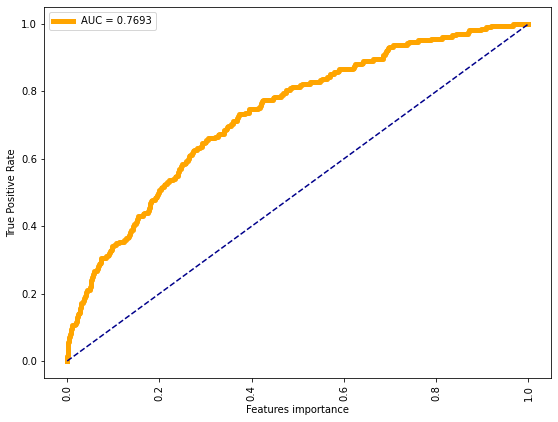

In [65]:
cf_matrix_roc_auc(rs_1, y_test, rs_1.predict(X_test), rs_1.predict_proba(X_test)[:,1])

# Le meilleur modèle

In [66]:
%%time
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
params = {'n_estimators':[400,500,1000,2000],
'learning_rate' :[0.1,0.2],
'colsample_bytree' : [0.3,0.4,0.5,0.6,0.7,0.8],
'reg_alpha' : [40, 50,60,70],
'reg_lambda': [10,20,30,40, 50,60,70],
'subsample': [0.1,0.2, 0.3,0.4, 0.5, 0.6],
'max_depth':[3,4,5,9,10,11],
'num_leaves':[10,11,12,13,20, 30,40],
'min_child_samples': [400, 500,600],
'min_child_weight':[9,10.0,1e-3, 1,1e1, 1e2],
'is_unbalance': [True]}

clf =  LGBMClassifier(boosting_type="gbdt",verbose=-1,n_jobs=-2,random_state=101,objective='binary')
gs = RandomizedSearchCV(clf, params, scoring='roc_auc', n_jobs=-1)
gs.fit(X_train, y_train)

print("Best set of Parameters",gs.best_params_)
roc_auc= gs.best_score_
print('Best Score : %0.4f' %roc_auc)
#print("Best Score",gs.best_score_)

Best set of Parameters {'subsample': 0.3, 'reg_lambda': 10, 'reg_alpha': 70, 'num_leaves': 20, 'n_estimators': 400, 'min_child_weight': 9, 'min_child_samples': 500, 'max_depth': 3, 'learning_rate': 0.1, 'is_unbalance': True, 'colsample_bytree': 0.3}
Best Score : 0.7708
CPU times: user 4.32 s, sys: 318 ms, total: 4.64 s
Wall time: 2min 57s


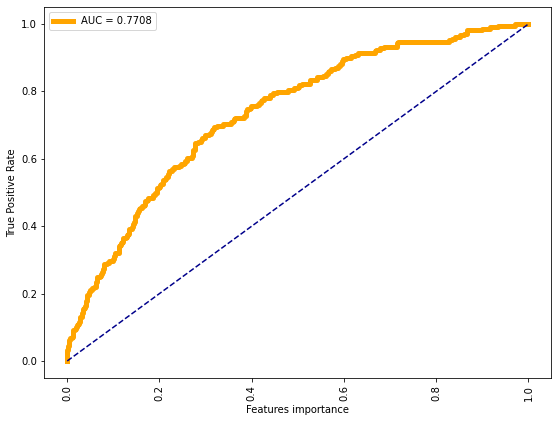

In [67]:
cf_matrix_roc_auc(gs, y_test, gs.predict(X_test), gs.predict_proba(X_test)[:,1])

# Suréchantillonnage des données à l'aide de SMOTE

In [68]:
print("Label 1, Before using SMOTE: {} ".format(sum(y_train==1)))
print("Label 0, Before using SMOTE: {} ".format(sum(y_train==0)))

Label 1, Before using SMOTE: 511 
Label 0, Before using SMOTE: 6489 


In [69]:
from imblearn.over_sampling import SMOTE
%time
sm = SMOTE(random_state=42)#sampling_strategy=0.1
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 8.11 µs


In [70]:
print("Label 1, After using SMOTE: {}".format(sum(y_train_res==1)))
print("Label 0, After using SMOTE: {}".format(sum(y_train_res==0)))

Label 1, After using SMOTE: 6489
Label 0, After using SMOTE: 6489


In [71]:
from imblearn.pipeline import Pipeline
dummy_clf_1 = Pipeline([
        ('sampling', SMOTE()),
        ('classification', DummyClassifier(strategy="most_frequent"))
    ])

dummy_clf_1=dummy_clf_1.fit(X_train, y_train)
roc_auc = roc_auc_score(y_test, dummy_clf_1.predict_proba(X_test)[:,1])
print('AUC : %0.3f' %roc_auc)

AUC : 0.500


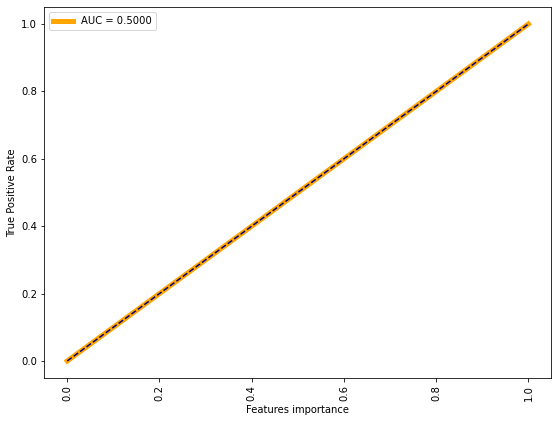

In [72]:
cf_matrix_roc_auc(dummy_clf_1, y_test, dummy_clf_1.predict(X_test), dummy_clf_1.predict_proba(X_test)[:,1])


In [73]:
# Initialze the estimators
clf1 = RandomForestClassifier(random_state=42)
clf2 = SVC(probability=True, random_state=42)
clf3 = LogisticRegression(random_state=42)
clf4 = DecisionTreeClassifier(random_state=42)
clf5 = KNeighborsClassifier()
clf6 = MultinomialNB()
clf7 = GradientBoostingClassifier(random_state=42)

In [74]:
# Initiaze the hyperparameters for each dictionary
param1 = {}
param1['classifier__n_estimators'] = [10, 50, 100, 250]
param1['classifier__max_depth'] = [5, 10, 20]
param1['classifier__class_weight'] = [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]
param1['classifier'] = [clf1]

param2 = {}
param2['classifier__C'] = [10**-2, 10**-1, 10**0, 10**1, 10**2]
param2['classifier__class_weight'] = [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]
param2['classifier'] = [clf2]

param3 = {}
param3['classifier__C'] = [10**-2, 10**-1, 10**0, 10**1, 10**2]
param3['classifier__penalty'] = ['l1', 'l2']
param3['classifier__class_weight'] = [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]
param3['classifier'] = [clf3]

param4 = {}
param4['classifier__max_depth'] = [5,10,25,None]
param4['classifier__min_samples_split'] = [2,5,10]
param4['classifier__class_weight'] = [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]
param4['classifier'] = [clf4]

param5 = {}
param5['classifier__n_neighbors'] = [2,5,10,25,50]
param5['classifier'] = [clf5]

param6 = {}
param6['classifier__alpha'] = [10**0, 10**1, 10**2]
param6['classifier'] = [clf6]

param7 = {}
param7['classifier__n_estimators'] = [10, 50, 100, 250]
param7['classifier__max_depth'] = [5, 10, 20]
param7['classifier'] = [clf7]

In [75]:
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
pipeline_1 = Pipeline([('sampling', SMOTE(random_state=42)),('classifier', clf1)])

params = [param1, param2, param3, param4, param5, param6, param7]

In [76]:
%%time
from sklearn.model_selection import RandomizedSearchCV
# Train the random search model
rs_2 = RandomizedSearchCV(pipeline_1, params, cv=3, n_jobs=-1, scoring='roc_auc').fit(X_train, y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
3 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/imblearn/pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  Fil

CPU times: user 12.1 s, sys: 343 ms, total: 12.4 s
Wall time: 7min 31s


In [77]:
# Best performing model and its corresponding hyperparameters
rs_2.best_params_

{'classifier__n_estimators': 250,
 'classifier__max_depth': 5,
 'classifier__class_weight': None,
 'classifier': RandomForestClassifier(max_depth=5, n_estimators=250, random_state=42)}

In [78]:
# ROC-AUC score for the best model
roc_auc= rs_2.best_score_
print('AUC : %0.4f' %roc_auc)

AUC : 0.7069


In [79]:
#'param_classifier'
pd.DataFrame(rs_2.cv_results_)[['param_classifier','mean_fit_time', 'split0_test_score',
       'split1_test_score', 'split2_test_score',
        'mean_test_score', 'rank_test_score']].sort_values(
    by='rank_test_score')

,param_classifier,mean_fit_time,split0_test_score,split1_test_score,split2_test_score,mean_test_score,rank_test_score
4,"RandomForestClassifier(max_depth=5, n_estimato...",11.355429,0.727909,0.714354,0.678442,0.706902,1
0,"RandomForestClassifier(max_depth=5, n_estimato...",11.531764,0.702670,0.707439,0.673135,0.694415,2
1,"RandomForestClassifier(max_depth=5, n_estimato...",4.426640,0.711431,0.688616,0.671374,0.690474,3
2,DecisionTreeClassifier(random_state=42),1.678817,0.678031,0.595740,0.612729,0.628833,4
8,"SVC(probability=True, random_state=42)",203.988391,0.606076,0.614498,0.587118,0.602564,5
5,"SVC(probability=True, random_state=42)",214.487752,0.562615,0.558103,0.584931,0.568550,6
6,DecisionTreeClassifier(random_state=42),4.602486,0.537414,0.539458,0.534244,0.537039,7
3,KNeighborsClassifier(),0.401618,0.562613,0.510677,0.535120,0.536137,8
9,DecisionTreeClassifier(random_state=42),3.651010,0.566035,0.495741,0.525217,0.528998,9
7,LogisticRegression(random_state=42),0.388822,NaN,NaN,NaN,NaN,10


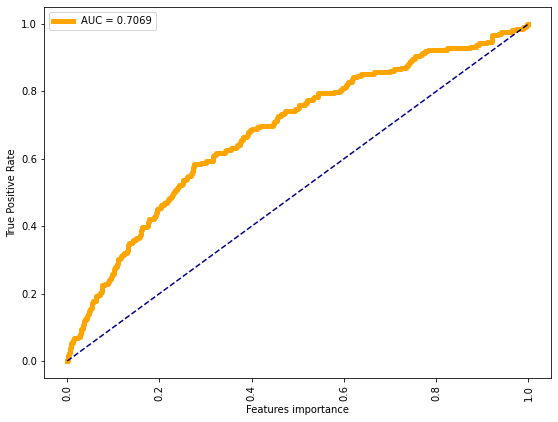

In [80]:
cf_matrix_roc_auc(rs_2, y_test, rs_2.predict(X_test), rs_2.predict_proba(X_test)[:,1])


In [81]:
# Initialze the estimators
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
clf8 = LGBMClassifier(boosting_type="gbdt",verbose=-1,n_jobs=-2,random_state=101,objective='binary')
clf9 = XGBClassifier(objective="binary:logistic",random_state=0)

In [82]:
# Initiaze the hyperparameters for each dictionary
param8 = {}
param8['classifier__n_estimators'] = [100,500,1000]
param8['classifier__learning_rate'] = [0.02, 0.05,0.1,0.2]
param8['classifier__colsample_bytree'] = [0.3,0.4,0.6]
param8['classifier__reg_alpha'] = [0,1,2, 50]
param8['classifier__reg_lambda'] = [0.01,0,1, 20, 50]
param8['classifier__subsample'] = [0.2, 0.5, 0.8]
param8['classifier__max_depth'] = [4, 7,8, 10,11,20]
param8['classifier__num_leaves'] = [6,10,11,20, 30]
param8['classifier__min_child_samples'] = [10,90,100,300, 500]
param8['classifier__min_child_weight'] = [1e-3, 1,1e1, 1e2]
param8['classifier'] = [clf8]

param9 = {}
param9['classifier__tree_method'] = ['gpu_hist', 'auto', 'exact', 'approx']
param9['classifier__predictor'] = ['auto', 'cpu_predictor', 'gpu_predictor']
param9['classifier__interaction_constraints']=[[0, 1], [2, 3, 4]] 
param9['classifier__scale_pos_weight']=[1,14.38] 
param9['classifier__max_delta_step']=[0,1,2,3,4,5,6,7,8,9,10]
param9['classifier'] = [clf9]

In [83]:
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
pipeline_2 = Pipeline([('sampling', SMOTE(random_state=42)),('classifier', clf8)])
params = [param8, param9]

In [84]:
%%time
from sklearn.model_selection import RandomizedSearchCV
# Train the random search model
rs_3 = RandomizedSearchCV(pipeline_2, params,cv=3, scoring='roc_auc').fit(X_train, y_train)

CPU times: user 7min 39s, sys: 9.27 s, total: 7min 48s
Wall time: 2min 5s


In [85]:
# Best performing model and its corresponding hyperparameters
rs_3.best_params_


{'classifier__subsample': 0.5,
 'classifier__reg_lambda': 50,
 'classifier__reg_alpha': 2,
 'classifier__num_leaves': 30,
 'classifier__n_estimators': 1000,
 'classifier__min_child_weight': 1,
 'classifier__min_child_samples': 500,
 'classifier__max_depth': 20,
 'classifier__learning_rate': 0.05,
 'classifier__colsample_bytree': 0.3,
 'classifier': LGBMClassifier(colsample_bytree=0.3, learning_rate=0.05, max_depth=20,
                min_child_samples=500, min_child_weight=1, n_estimators=1000,
                n_jobs=-2, num_leaves=30, objective='binary', random_state=101,
                reg_alpha=2, reg_lambda=50, subsample=0.5, verbose=-1)}

In [86]:
# ROC-AUC score for the best model
roc_auc= rs_3.best_score_
print('AUC : %0.4f' %roc_auc)

AUC : 0.7605


In [87]:
#'param_classifier'
pd.DataFrame(rs_3.cv_results_)[['param_classifier','mean_fit_time', 'split0_test_score',
       'split1_test_score', 'split2_test_score',
        'mean_test_score', 'rank_test_score']].sort_values(
    by='rank_test_score')

,param_classifier,mean_fit_time,split0_test_score,split1_test_score,split2_test_score,mean_test_score,rank_test_score
7,"LGBMClassifier(colsample_bytree=0.3, learning_...",5.430660,0.780919,0.760099,0.740363,0.760461,1
2,"LGBMClassifier(colsample_bytree=0.3, learning_...",6.194454,0.772168,0.759745,0.749128,0.760347,2
8,"LGBMClassifier(colsample_bytree=0.3, learning_...",4.979176,0.763300,0.753461,0.739561,0.752107,3
3,"LGBMClassifier(colsample_bytree=0.3, learning_...",2.838736,0.763303,0.749523,0.734875,0.749234,4
9,"LGBMClassifier(colsample_bytree=0.3, learning_...",3.207090,0.760672,0.748952,0.732080,0.747234,5
5,"LGBMClassifier(colsample_bytree=0.3, learning_...",7.115860,0.759255,0.742977,0.730078,0.744103,6
6,"LGBMClassifier(colsample_bytree=0.3, learning_...",2.829485,0.751069,0.749370,0.718449,0.739629,7
4,"LGBMClassifier(colsample_bytree=0.3, learning_...",1.615655,0.759212,0.738568,0.718844,0.738875,8
0,"LGBMClassifier(colsample_bytree=0.3, learning_...",1.274436,0.750915,0.721715,0.702856,0.725162,9
1,"LGBMClassifier(colsample_bytree=0.3, learning_...",3.084452,0.729683,0.732460,0.703761,0.721968,10


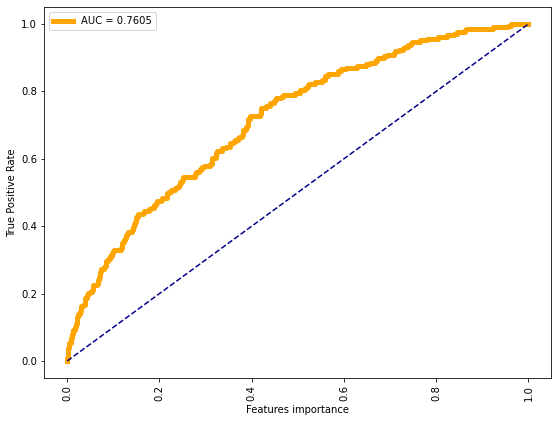

In [88]:
cf_matrix_roc_auc(rs_3, y_test, rs_3.predict(X_test), rs_3.predict_proba(X_test)[:,1])


# Le meilleur modèle avec SMOTE

In [89]:
%%time
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
params = {'classifier__n_estimators': [900,1000,1500],
'classifier__learning_rate': [0.04,0.05,0.06],
'classifier__colsample_bytree': [0.2,0.3,0.4,0.5,0.6,0.7],
'classifier__reg_alpha': [1,2, 3,4],
'classifier__reg_lambda': [40, 50,60,70],
'classifier__subsample': [0.4,0.5,0.6,0.7,0.8, 0.9],
'classifier__max_depth': [10,20,30,40],
'classifier__num_leaves': [20, 30,40],
'classifier__min_child_samples': [400, 500,600,700],
'classifier__min_child_weight': [0,1,1e-3, 1,1e1, 1e2]}

clf_1 = Pipeline([('sampling', SMOTE()),('classifier',LGBMClassifier(boosting_type="gbdt",verbose=-1,n_jobs=-2,random_state=101,objective='binary',class_weight='balanced'))])
gs_2 = RandomizedSearchCV(clf_1, params, scoring='roc_auc')
gs_2.fit(X_train, y_train)

print("Best set of Parameters",gs_2.best_params_)
roc_auc= gs_2.best_score_
print('Best Score : %0.4f' %roc_auc)
#print("",gs_1.best_score_)

Best set of Parameters {'classifier__subsample': 0.7, 'classifier__reg_lambda': 60, 'classifier__reg_alpha': 3, 'classifier__num_leaves': 40, 'classifier__n_estimators': 1500, 'classifier__min_child_weight': 100.0, 'classifier__min_child_samples': 500, 'classifier__max_depth': 20, 'classifier__learning_rate': 0.05, 'classifier__colsample_bytree': 0.4}
Best Score : 0.7601
CPU times: user 37min 13s, sys: 22.9 s, total: 37min 36s
Wall time: 9min 46s


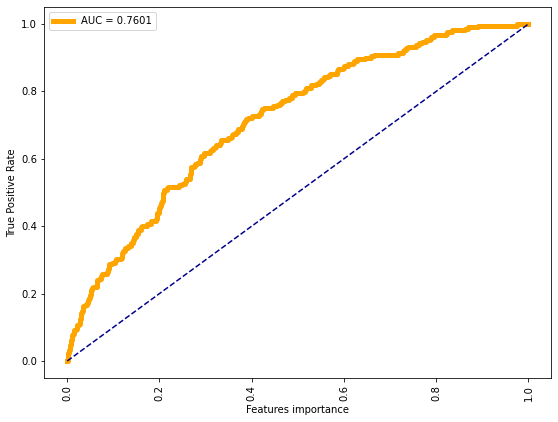

In [90]:
cf_matrix_roc_auc(gs_2, y_test, gs_2.predict(X_test), gs_2.predict_proba(X_test)[:,1])


# Fonction coût


In [91]:
# Initialze the estimators
clf1 = RandomForestClassifier(random_state=42)
clf2 = SVC(probability=True, random_state=42)
clf3 = LogisticRegression(random_state=42)
clf4 = DecisionTreeClassifier(random_state=42)
clf5 = KNeighborsClassifier()
clf6 = MultinomialNB()
clf7 = GradientBoostingClassifier(random_state=42)

In [92]:
# Initiaze the hyperparameters for each dictionary
param1 = {}
param1['classifier__n_estimators'] = [10, 50, 100, 250]
param1['classifier__max_depth'] = [5, 10, 20]
param1['classifier__class_weight'] = [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]
param1['classifier'] = [clf1]

param2 = {}
param2['classifier__C'] = [10**-2, 10**-1, 10**0, 10**1, 10**2]
param2['classifier__class_weight'] = [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]
param2['classifier'] = [clf2]

param3 = {}
param3['classifier__C'] = [10**-2, 10**-1, 10**0, 10**1, 10**2]
param3['classifier__penalty'] = ['l1', 'l2']
param3['classifier__class_weight'] = [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]
param3['classifier'] = [clf3]

param4 = {}
param4['classifier__max_depth'] = [5,10,25,None]
param4['classifier__min_samples_split'] = [2,5,10]
param4['classifier__class_weight'] = [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]
param4['classifier'] = [clf4]

param5 = {}
param5['classifier__n_neighbors'] = [2,5,10,25,50]
param5['classifier'] = [clf5]

param6 = {}
param6['classifier__alpha'] = [10**0, 10**1, 10**2]
param6['classifier'] = [clf6]

param7 = {}
param7['classifier__n_estimators'] = [10, 50, 100, 250]
param7['classifier__max_depth'] = [5, 10, 20]
param7['classifier'] = [clf7]

In [93]:
from sklearn.pipeline import Pipeline
pipeline = Pipeline([('classifier', clf1)])
params = [param1, param2, param3, param4, param5, param6, param7]

In [94]:
%%time
from sklearn.metrics import fbeta_score, make_scorer
ftwo_scorer = make_scorer(fbeta_score, beta=2)
ftwo_scorer
from sklearn.model_selection import RandomizedSearchCV
# Train the random search model
rs_4 = RandomizedSearchCV(pipeline, params, cv=3, n_jobs=-1, scoring=ftwo_scorer).fit(X_train, y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
3 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

CPU times: user 1.01 s, sys: 368 ms, total: 1.38 s
Wall time: 5min 19s


In [95]:
# Best performing model and its corresponding hyperparameters
rs_4.best_params_

{'classifier__min_samples_split': 10,
 'classifier__max_depth': 5,
 'classifier__class_weight': {0: 1, 1: 10},
 'classifier': DecisionTreeClassifier(class_weight={0: 1, 1: 10}, max_depth=5,
                        min_samples_split=10, random_state=42)}

In [96]:
fbeta= rs_4.best_score_
print('f_beta : %0.4f' %fbeta)

f_beta : 0.3300


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [97]:
# Initialze the estimators
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
clf8 = LGBMClassifier(boosting_type="gbdt",verbose=-1,n_jobs=-2,random_state=101,objective='binary')
clf9 = XGBClassifier(objective="binary:logistic",random_state=0)

In [98]:
# Initiaze the hyperparameters for each dictionary
param8 = {}
param8['classifier__n_estimators'] = [100,500,1000]
param8['classifier__learning_rate'] = [0.02, 0.05,0.1,0.2]
param8['classifier__colsample_bytree'] = [0.3,0.4,0.6]
param8['classifier__reg_alpha'] = [0,1,2, 50]
param8['classifier__reg_lambda'] = [0.01,0,1, 20, 50]
param8['classifier__subsample'] = [0.2, 0.5, 0.8]
param8['classifier__max_depth'] = [4, 7,8, 10,11,20]
param8['classifier__num_leaves'] = [6,10,11,20, 30]
param8['classifier__min_child_samples'] = [10,90,100,300, 500]
param8['classifier__min_child_weight'] = [1e-3, 1,1e1, 1e2]
param8['classifier__is_unbalance'] =[True]
param8['classifier'] = [clf8]

param9 = {}
param9['classifier__tree_method'] = ['gpu_hist', 'auto', 'exact', 'approx']
param9['classifier__predictor'] = ['auto', 'cpu_predictor', 'gpu_predictor']
param9['classifier__interaction_constraints']=[[0, 1], [2, 3, 4]] 
param9['classifier__scale_pos_weight']=[1,14.38] 
param9['classifier__max_delta_step']=[0,1,2,3,4,5,6,7,8,9,10]
param9['classifier'] = [clf9]

In [99]:
from sklearn.pipeline import Pipeline
pipeline = Pipeline([('classifier', clf8)])
params = [param8, param9]

In [100]:
%%time
from sklearn.metrics import fbeta_score, make_scorer
ftwo_scorer = make_scorer(fbeta_score, beta=2)
ftwo_scorer
from sklearn.model_selection import RandomizedSearchCV
# Train the random search model
rs_5 = RandomizedSearchCV(pipeline, params, cv=3, n_jobs=-1, scoring=ftwo_scorer).fit(X_train, y_train)

CPU times: user 3.57 s, sys: 170 ms, total: 3.74 s
Wall time: 1min 2s


In [101]:
# Best performing model and its corresponding hyperparameters
rs_5.best_params_

{'classifier__subsample': 0.8,
 'classifier__reg_lambda': 0,
 'classifier__reg_alpha': 1,
 'classifier__num_leaves': 10,
 'classifier__n_estimators': 100,
 'classifier__min_child_weight': 1,
 'classifier__min_child_samples': 300,
 'classifier__max_depth': 4,
 'classifier__learning_rate': 0.05,
 'classifier__is_unbalance': True,
 'classifier__colsample_bytree': 0.4,
 'classifier': LGBMClassifier(colsample_bytree=0.4, is_unbalance=True, learning_rate=0.05,
                max_depth=4, min_child_samples=300, min_child_weight=1,
                n_jobs=-2, num_leaves=10, objective='binary', random_state=101,
                reg_alpha=1, reg_lambda=0, subsample=0.8, verbose=-1)}

In [102]:
fbeta= rs_5.best_score_
print('f_beta : %0.4f' %fbeta)

f_beta : 0.4072


# Avec SMOTE

In [103]:
# Initialze the estimators
clf1 = RandomForestClassifier(random_state=42)
clf2 = SVC(probability=True, random_state=42)
clf3 = LogisticRegression(random_state=42)
clf4 = DecisionTreeClassifier(random_state=42)
clf5 = KNeighborsClassifier()
clf6 = MultinomialNB()
clf7 = GradientBoostingClassifier(random_state=42)

In [104]:
# Initiaze the hyperparameters for each dictionary
param1 = {}
param1['classifier__n_estimators'] = [10, 50, 100, 250]
param1['classifier__max_depth'] = [5, 10, 20]
param1['classifier__class_weight'] = [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]
param1['classifier'] = [clf1]

param2 = {}
param2['classifier__C'] = [10**-2, 10**-1, 10**0, 10**1, 10**2]
param2['classifier__class_weight'] = [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]
param2['classifier'] = [clf2]

param3 = {}
param3['classifier__C'] = [10**-2, 10**-1, 10**0, 10**1, 10**2]
param3['classifier__penalty'] = ['l1', 'l2']
param3['classifier__class_weight'] = [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]
param3['classifier'] = [clf3]

param4 = {}
param4['classifier__max_depth'] = [5,10,25,None]
param4['classifier__min_samples_split'] = [2,5,10]
param4['classifier__class_weight'] = [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]
param4['classifier'] = [clf4]

param5 = {}
param5['classifier__n_neighbors'] = [2,5,10,25,50]
param5['classifier'] = [clf5]

param6 = {}
param6['classifier__alpha'] = [10**0, 10**1, 10**2]
param6['classifier'] = [clf6]

param7 = {}
param7['classifier__n_estimators'] = [10, 50, 100, 250]
param7['classifier__max_depth'] = [5, 10, 20]
param7['classifier'] = [clf7]

In [105]:
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
pipeline_1 = Pipeline([('sampling', SMOTE(random_state=42)),('classifier', clf1)])

params = [param1, param2, param3, param4, param5, param6, param7]

In [106]:
%%time
from sklearn.metrics import fbeta_score, make_scorer
ftwo_scorer = make_scorer(fbeta_score, beta=2)
ftwo_scorer
from sklearn.model_selection import RandomizedSearchCV
# Train the random search model
rs_6 = RandomizedSearchCV(pipeline_1, params, cv=3, n_jobs=-1, scoring=ftwo_scorer).fit(X_train, y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
3 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/imblearn/pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  Fil

CPU times: user 4.84 s, sys: 355 ms, total: 5.19 s
Wall time: 24.2 s


In [107]:
# Best performing model and its corresponding hyperparameters
rs_6.best_params_

{'classifier__n_estimators': 50,
 'classifier__max_depth': 10,
 'classifier__class_weight': {0: 1, 1: 10},
 'classifier': RandomForestClassifier(class_weight={0: 1, 1: 10}, max_depth=10,
                        n_estimators=50, random_state=42)}

In [108]:
fbeta= rs_6.best_score_
print('f_beta : %0.4f' %fbeta)

f_beta : 0.3252


In [109]:
# Initialze the estimators
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
clf8 = LGBMClassifier(boosting_type="gbdt",verbose=-1,n_jobs=-2,random_state=101,objective='binary')
clf9 = XGBClassifier(objective="binary:logistic",random_state=0)

In [110]:
# Initiaze the hyperparameters for each dictionary
param8 = {}
param8['classifier__n_estimators'] = [100,500,1000]
param8['classifier__learning_rate'] = [0.02, 0.05,0.1,0.2]
param8['classifier__colsample_bytree'] = [0.3,0.4,0.6]
param8['classifier__reg_alpha'] = [0,1,2, 50]
param8['classifier__reg_lambda'] = [0.01,0,1, 20, 50]
param8['classifier__subsample'] = [0.2, 0.5, 0.8]
param8['classifier__max_depth'] = [4, 7,8, 10,11,20]
param8['classifier__num_leaves'] = [6,10,11,20, 30]
param8['classifier__min_child_samples'] = [10,90,100,300, 500]
param8['classifier__min_child_weight'] = [1e-3, 1,1e1, 1e2]
param8['classifier'] = [clf8]

param9 = {}
param9['classifier__tree_method'] = ['gpu_hist', 'auto', 'exact', 'approx']
param9['classifier__predictor'] = ['auto', 'cpu_predictor', 'gpu_predictor']
param9['classifier__interaction_constraints']=[[0, 1], [2, 3, 4]] 
param9['classifier__scale_pos_weight']=[1,14.38] 
param9['classifier__max_delta_step']=[0,1,2,3,4,5,6,7,8,9,10]
param9['classifier'] = [clf9]

In [111]:
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
pipeline_2 = Pipeline([('sampling', SMOTE(random_state=42)),('classifier', clf8)])
params = [param8, param9]

In [112]:
%%time
from sklearn.metrics import fbeta_score, make_scorer
ftwo_scorer = make_scorer(fbeta_score, beta=2)
ftwo_scorer
from sklearn.model_selection import RandomizedSearchCV
# Train the random search model
rs_7 = RandomizedSearchCV(pipeline_2, params, cv=3, n_jobs=-1, scoring=ftwo_scorer).fit(X_train, y_train)

CPU times: user 18.1 s, sys: 377 ms, total: 18.5 s
Wall time: 1min 44s


In [113]:
# Best performing model and its corresponding hyperparameters
rs_7.best_params_

{'classifier__subsample': 0.8,
 'classifier__reg_lambda': 50,
 'classifier__reg_alpha': 0,
 'classifier__num_leaves': 6,
 'classifier__n_estimators': 500,
 'classifier__min_child_weight': 100.0,
 'classifier__min_child_samples': 90,
 'classifier__max_depth': 4,
 'classifier__learning_rate': 0.2,
 'classifier__colsample_bytree': 0.6,
 'classifier': LGBMClassifier(colsample_bytree=0.6, learning_rate=0.2, max_depth=4,
                min_child_samples=90, min_child_weight=100.0, n_estimators=500,
                n_jobs=-2, num_leaves=6, objective='binary', random_state=101,
                reg_alpha=0, reg_lambda=50, subsample=0.8, verbose=-1)}

In [114]:
fbeta= rs_7.best_score_
print('f_beta : %0.4f' %fbeta)

f_beta : 0.0764


# Matrice de confusion

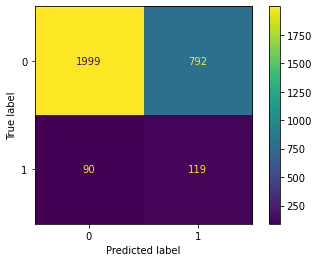

In [115]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

y_pred = rs_4.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

cm_display = ConfusionMatrixDisplay(cm).plot()

In [116]:
90*10+792

1692

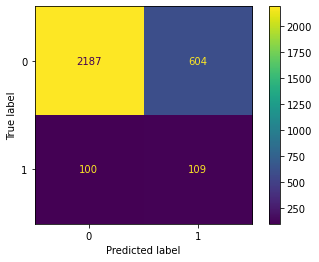

In [117]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

y_pred = rs_5.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

cm_display = ConfusionMatrixDisplay(cm).plot()

In [118]:
#10*FN + FP
10*100+604


1604

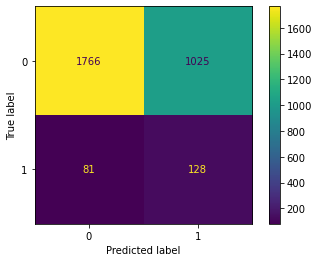

In [119]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

y_pred = rs_6.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

cm_display = ConfusionMatrixDisplay(cm).plot()

In [120]:
81*10+1025

1835

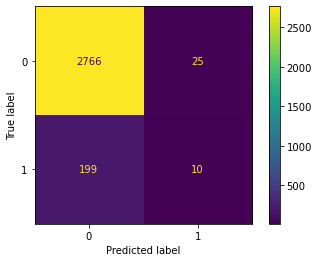

In [121]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

y_pred = rs_7.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

cm_display = ConfusionMatrixDisplay(cm).plot()

In [122]:
199*10+25

2015

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
